In [481]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib_venn import venn2
from src.tests.team_2.model_trainer_2 import load_data
from src.tests.team_2.model_trainer_2 import retrain
from src.utils.feature_analyzer import *
from src.utils.plot_utils import plot_distribution
from src.utils.test_utils import *



In [482]:
###PIPELINE###
# 1 load training data
# 2 evaluate feature importance with permutation feature
# 3 select top feature to create a test for bias
# 5 test if there is actually bias
# 6 choose that feature or not.
# 7 remove feature from training data
# 8 repeat (2-7) until we have 5 features we believe have the most bias



In [483]:
biased_features = []

In [484]:
###TRAIN: no features removed
# X, y = load_data('../../data/synth_data_train_labeled.csv')
# retrain(X, y)

In [485]:
###LOAD DATA
RANDOM_STATE = 42

# Load in data (go back two parent directories)
df = pd.read_csv('data/investigation_train_large_checked.csv')
# Load in data descriptions
data_desc = pd.read_csv('data/data_description.csv', encoding='ISO-8859-1')

# Replace dutch for english names
name_mapping = dict(zip(data_desc['Feature (nl)'], data_desc['Feature (en)']))
# Rename the columns in the `data` DataFrame
df.rename(columns=name_mapping, inplace=True)

# Show data head
df.head()


,address_number_personal_records_database_addresses,address_number_different_districts,address_number_mail_address,address_number_residential_address_manual,address_days_at_address,address_latest_part_rotterdam,address_latest_neighborhood_groot_ijsselmonde,address_latest_neighborhood_new_westen,address_latest_neighborhood_other,address_latest_neighborhood_olde_north,...,type_hist_ind,type_hist_care_sector,type_ind,type_indication_secret_data,type_other,type_transport_logistics_horticulture,type_care_cleaning_wellbeing,Ja,Nee,checked
0,1,1,0,0,23240,1,0,0,0,0,...,1,0,0,0,0,0,0,0.617698,0.382302,False
1,4,2,1,1,1971,1,0,0,1,0,...,1,0,1,0,1,0,0,0.602167,0.397833,False
2,6,4,2,1,7247,0,0,0,1,0,...,1,0,1,0,0,0,0,0.512377,0.487623,False
3,3,2,0,1,8060,1,0,0,1,0,...,1,0,0,0,0,0,0,0.717796,0.282204,True
4,3,2,0,0,18705,1,0,0,0,0,...,1,0,1,0,0,0,0,0.705484,0.294516,True


In [486]:
def analyze_features(data, cache, filename):
    fa = FeatureAnalyzer()
    if cache:
        fa.evaluate_importance(dataframe=data, target='checked', add_drop=['Ja', 'Nee'], filepath=filename)
    fa = FeatureAnalyzer()
    fa.load_importance(filepath=filename)

    # Select original training data
    X = df.drop(['checked', 'Ja', 'Nee'], axis=1)
    y = df['checked']
    # Convert permutation importance to dictionary
    perm_import = fa.feature_importance_as_dict(column_names=X.columns, normalize=True)
    # Convert to pd series and sort from high to low
    perm_import = pd.Series(perm_import)
    # sort from high to low
    sorted_perm = perm_import.sort_values(ascending=False)

    top_5 = sorted_perm.head(5)
    top_5_sorted = top_5.sort_values(ascending=True)

    # Set the figure size for better readability
    plt.figure(figsize=(10,4))

    # Create a horizontal bar chart
    top_5_sorted.plot(kind='barh', color='skyblue')

    # Add titles and labels
    plt.title('Top 5 Feature based on Permutation Importances', fontsize=16)
    plt.xlabel('Importance Score', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    # Display sorted value
    for i, (value, feature) in enumerate(zip(top_5_sorted.values, top_5_sorted.index)):
        plt.text(value, i, f' {value:.2f}', va='center')
    # Enhance layout for better spacing
    plt.tight_layout()
    # Display the plot
    plt.show()


In [487]:
def plot_values(feature, data):
    counts = data[feature].value_counts().sort_index()

    plt.figure(figsize=(8,2))
    counts.plot(kind='bar', color='skyblue')
    plt.title(f'Frequency of {feature}', fontsize=14)
    plt.xlabel(f'{feature}', fontsize=14)
    plt.ylabel('Counts', fontsize=14)

In [488]:
def process_bias(data_path, model_path, feature, new_value, is_range, detailed_results, name_original=None, name_changed=None):
    if is_range:
        acc_original, acc_changed, p_value, dataset_size, original_checked_cnt, changed_checked_cnt = test_bias_with_range(
            data_path, model_path, feature, new_value)
    else:
        acc_original, acc_changed, p_value, dataset_size, original_checked_cnt, changed_checked_cnt = test_bias(
            data_path, model_path, feature, new_value)

    if detailed_results:
        show_stats(dataset_size, acc_original, name_original, acc_changed, name_changed, original_checked_cnt, changed_checked_cnt)

    if p_value < 0.05:
        print(p_value)
        print(f'Model showcases significant bias towards feature - {feature}')
    elif p_value > 0.05:
        print(p_value)
        print(f'Model does not showcase significant bias towards feature - {feature}')

def show_stats(dataset_size, acc_original, f_name_original, acc_changed, f_name_changed, original_checked_cnt, changed_checked_cnt):
    print(f'Accuracy for sample of {dataset_size} {f_name_original}: {acc_original * 100:.1f}%')
    print(f'Accuracy for sample of {dataset_size} {f_name_changed}: {acc_changed * 100:.1f}%')
    print(f'Percentage checked amongst {f_name_original}: {original_checked_cnt * 100 / dataset_size:.1f}%')
    print(f'Percentage checked changed to {f_name_changed}: {changed_checked_cnt * 100 / dataset_size:.1f}%')

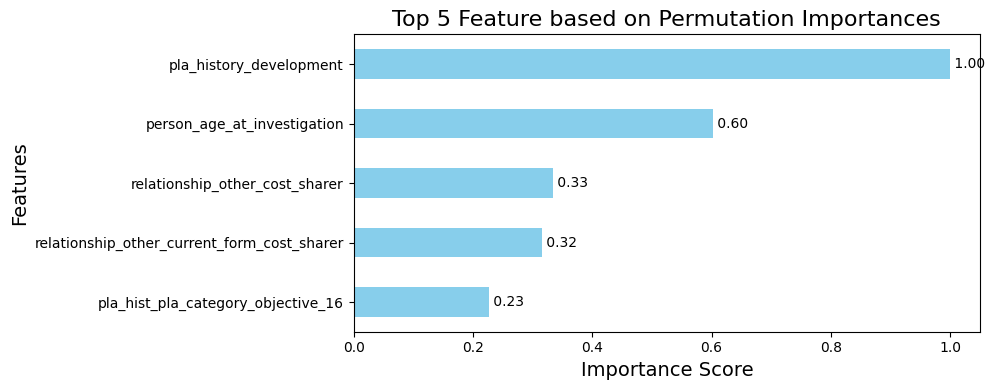

In [489]:
#ANALYZE: no features removed
analyze_features(df, False, 'src/team_2/feature_importance/fi_v0.pkl')

{'18-23': 22400, '23-28': 20600, '28-33': 17500, '33-38': 12900, '38-42': 10800, '42-47': 3000, '52-57': 800, '57-62': 4600, '62-67': 11700}


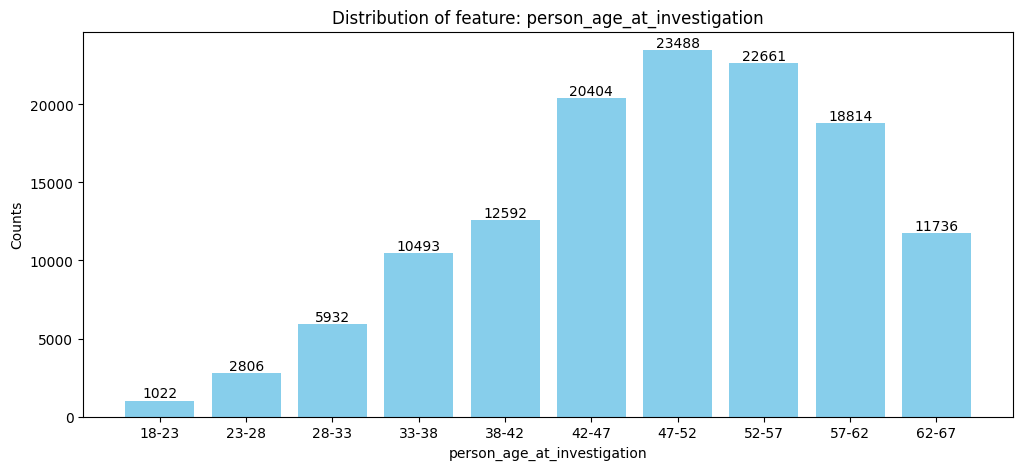

In [490]:
plot_distribution(df['person_age_at_investigation'], 'person_age_at_investigation')

In [491]:
###TEST: bias on age
only = pd.read_csv('data/Experiment_persoon_leeftijd_bij_onderzoek/20_only.csv')
only.head(10)



process_bias(
    data_path='data/Experiment_persoon_leeftijd_bij_onderzoek/20_only.csv',
    model_path='model/gboost1_v1.onnx',
    feature=['persoon_leeftijd_bij_onderzoek'],
    new_value=[50],
    is_range=False,
    detailed_results=True,
    name_original='20 year old',
    name_changed='18 year old'
)


Accuracy for sample of 500 20 year old: 88.8%
Accuracy for sample of 500 18 year old: 82.0%
Percentage checked amongst 20 year old: 49.4%
Percentage checked changed to 18 year old: 31.8%
1.1579228413454308e-08
Model showcases significant bias towards feature - ['persoon_leeftijd_bij_onderzoek']


In [492]:
###FEATURE SELECTION
biased_features.append('persoon_leeftijd_bij_onderzoek')

In [493]:
df = df.drop(name_mapping['persoon_leeftijd_bij_onderzoek'], axis=1)

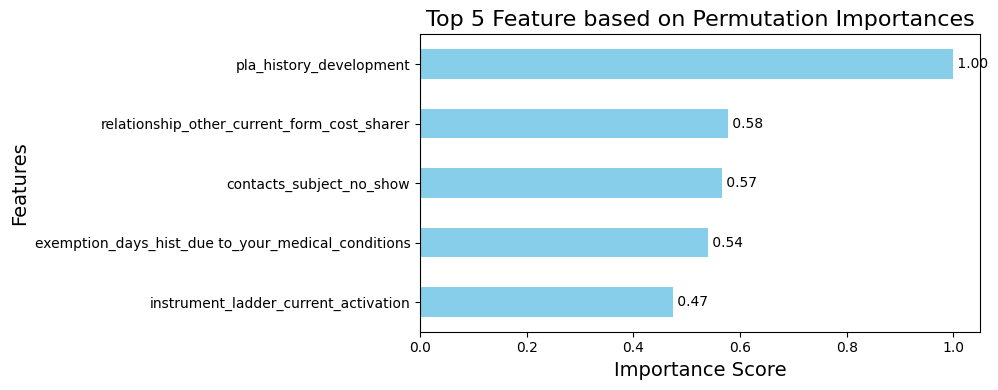

In [494]:
### Get feature importance for dataframe without persoon_leeftijd_bij_onderzoek

###REPEAT STEPS
analyze_features(df, False, 'src/team_2/feature_importance/fi_v1.pkl')

{0: 31000}


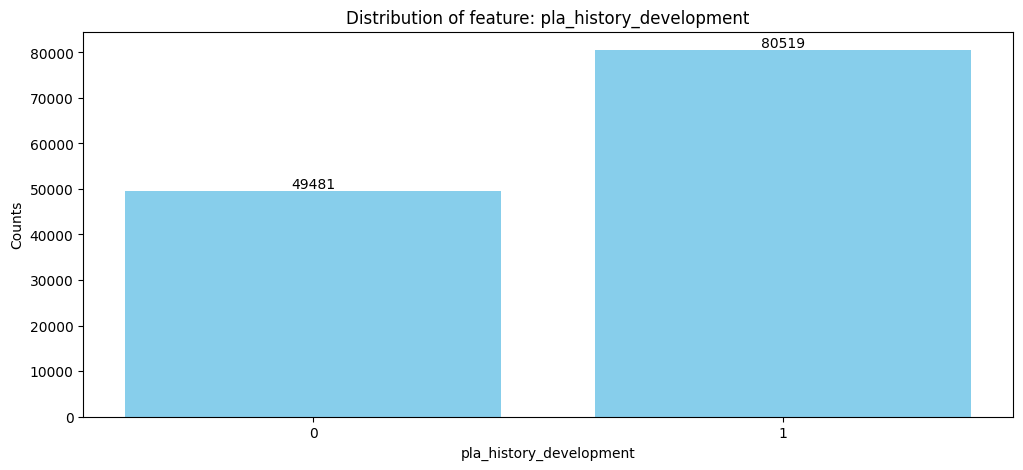

In [495]:
plot_distribution(df['pla_history_development'], 'pla_history_development')

In [496]:
###TEST: bias on history of plans
process_bias(
    data_path='data/Experiment_pla_historie_ontwikkeling/0_only.csv',
    model_path='model/gboost1_v1.onnx',
    feature=['pla_historie_ontwikkeling'],
    new_value=[1],
    is_range=False,
    detailed_results=True,
    name_original='Had no action plan (0)',
    name_changed='Had action plan (1)'
)

Accuracy for sample of 500 Had no action plan (0): 94.4%
Accuracy for sample of 500 Had action plan (1): 85.4%
Percentage checked amongst Had no action plan (0): 41.8%
Percentage checked changed to Had action plan (1): 28.8%
1.5907344288089193e-05
Model showcases significant bias towards feature - ['pla_historie_ontwikkeling']


In [497]:
###FEATURE SELECTION
biased_features.append('pla_historie_ontwikkeling')

In [498]:
df = df.drop(name_mapping['pla_historie_ontwikkeling'], axis=1)

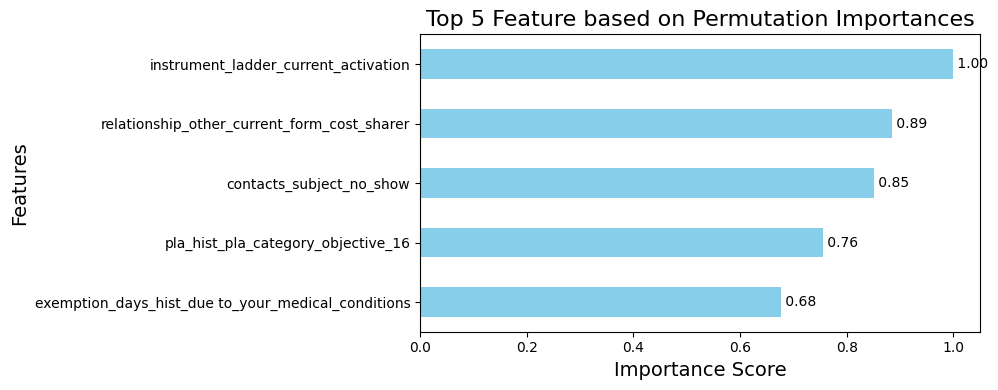

In [499]:
###REPEAT
analyze_features(df, False, 'src/team_2/feature_importance/fi_v2.pkl')

{1: 1000, 2: 54700, 3: 61700}


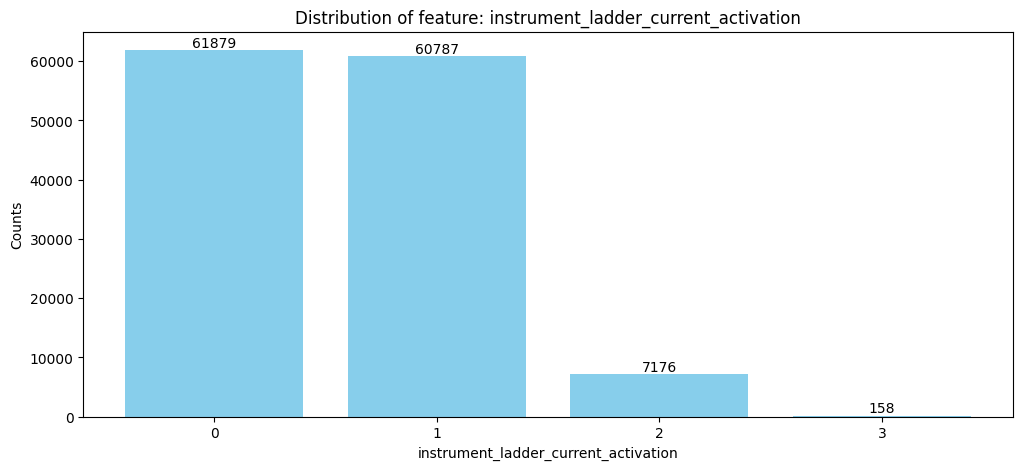

In [500]:
plot_distribution(df['instrument_ladder_current_activation'], 'instrument_ladder_current_activation')

In [501]:
###TEST
process_bias(
    data_path='data/Experiment_instrument_ladder_huidig_activering/01_curr_inst_2-3_labeled.csv',
    model_path='model/gboost1_v1.onnx',
    feature='instrument_ladder_huidig_activering',
    new_value=(0,1),
    is_range=True,
    detailed_results=True,
    name_original='Curr number of instruments: 2-3',
    name_changed='Curr number of instruments: 0-1'
)

Accuracy for sample of 500 Curr number of instruments: 2-3: 98.4%
Accuracy for sample of 500 Curr number of instruments: 0-1: 97.4%
Percentage checked amongst Curr number of instruments: 2-3: 1.6%
Percentage checked changed to Curr number of instruments: 0-1: 3.8%
0.03187998804736091
Model showcases significant bias towards feature - instrument_ladder_huidig_activering


In [502]:
biased_features.append('instrument_ladder_huidig_activering')
biased_features

['persoon_leeftijd_bij_onderzoek',
 'pla_historie_ontwikkeling',
 'instrument_ladder_huidig_activering']

In [503]:
df = df.drop(name_mapping['instrument_ladder_huidig_activering'], axis=1)

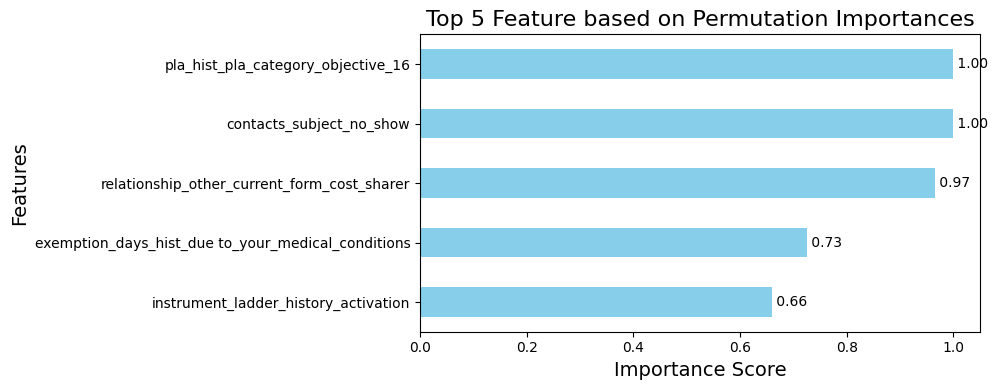

In [504]:
###REPEAT
analyze_features(df, False, 'src/team_2/feature_importance/fi_v3.pkl')

{0: 23900, 2: 30200, 3: 50500, 4: 57000, 5: 58200, 6: 58300}


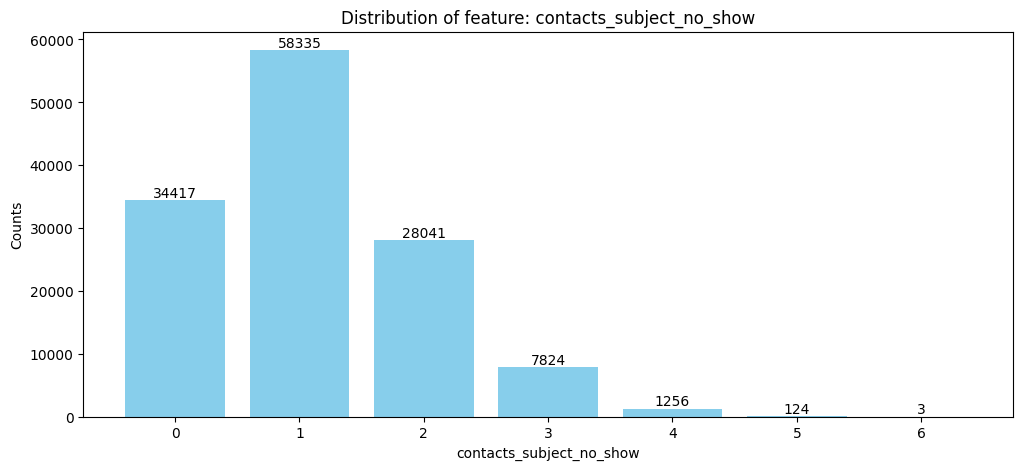

In [505]:
plot_distribution(df['contacts_subject_no_show'], 'contacts_subject_no_show')

In [506]:
process_bias(
    data_path='data/Experiment_contacten_onderwerp_no_show/02_contact_3-6_labeled.csv',
    model_path='model/gboost1_v1.onnx',
    feature='contacten_onderwerp_no_show',
    new_value=(0,2),
    is_range=True,
    detailed_results=True,
    name_original='No show count: 3-6',
    name_changed='No show count: 0-2'
)

Accuracy for sample of 1500 No show count: 3-6: 90.7%
Accuracy for sample of 1500 No show count: 0-2: 83.3%
Percentage checked amongst No show count: 3-6: 26.9%
Percentage checked changed to No show count: 0-2: 15.2%
3.3517710193528744e-15
Model showcases significant bias towards feature - contacten_onderwerp_no_show


In [507]:
biased_features.append('contacten_onderwerp_no_show')

In [508]:
df = df.drop(name_mapping['contacten_onderwerp_no_show'], axis=1)

In [ ]:
analyze_features(df, False, 'src/team_2/feature_importance/fi_v4.pkl')

{0: 5700, 2: 57500, 3: 64200}


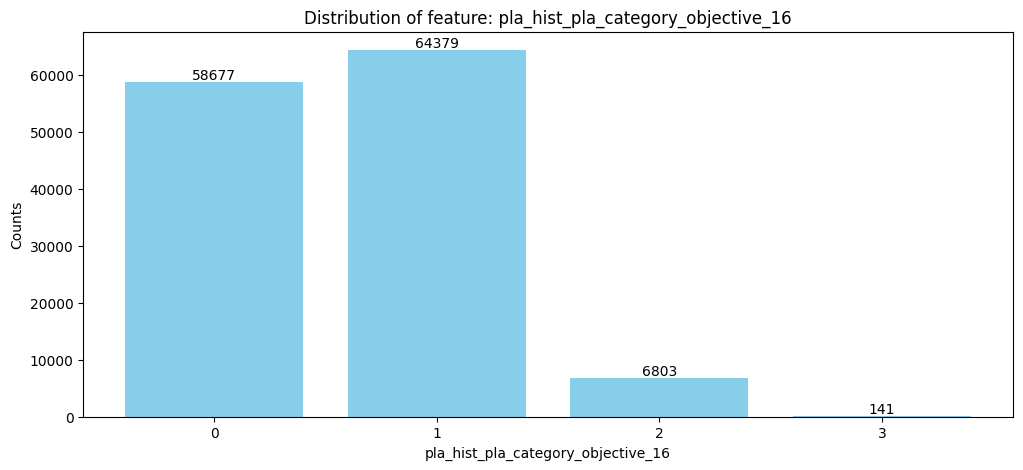

In [ ]:
plot_distribution(df['pla_hist_pla_category_objective_16'], 'pla_hist_pla_category_objective_16')

In [ ]:
process_bias(
    data_path='data/Experiment_pla_hist_pla_categorie_doelstelling_16/03_obj_16_2-3_labeled.csv',
    model_path='model/gboost1_v1.onnx',
    feature='pla_hist_pla_categorie_doelstelling_16',
    new_value=(0,1),
    is_range=True,
    detailed_results=True,
    name_original='Obj 16 count: 2-3',
    name_changed='Obj 16 count: 0-1'
)

Accuracy for sample of 1000 Obj 16 count: 2-3: 99.3%
Accuracy for sample of 1000 Obj 16 count: 0-1: 99.4%
Percentage checked amongst Obj 16 count: 2-3: 2.0%
Percentage checked changed to Obj 16 count: 0-1: 2.1%
0.8746920808141505
Model does not showcase significant bias towards feature - pla_hist_pla_categorie_doelstelling_16


In [479]:
biased_features.append('')
biased_features

['persoon_leeftijd_bij_onderzoek',
 'pla_historie_ontwikkeling',
 'instrument_ladder_huidig_activering',
 'contacten_onderwerp_no_show',
 '']

### Data Manipulation

In [ ]:
###Testing and example usage of manipulator
test_data = pd.read_csv('data/synth_data_train_labeled.csv')
test_data.describe()

FileNotFoundError: [Errno 2] No such file or directory: '../../data/synth_data_train_labeled.csv'

In [70]:
from src.tests.team_2.model_trainer_2 import data_manipulator

manipulated_data = data_manipulator(
    data=test_data,
    feature='persoon_leeftijd_bij_onderzoek',
    manipulation='remove',
    fraction=0.5,
    remove_condition=lambda row: row['persoon_leeftijd_bij_onderzoek'] > 30
)
manipulated_data.describe()

,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_hist_inburgeringsbehoeftig,typering_hist_ind,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn,Ja,Nee
count,52197.000000,52197.000000,52197.000000,52197.000000,52197.000000,52197.000000,52197.000000,52197.000000,52197.000000,52197.000000,...,52197.000000,52197.0,52197.000000,52197.000000,52197.000000,52197.000000,52197.000000,52197.000000,52197.000000,52197.000000
mean,2.915302,2.112037,0.432918,0.500546,9722.124049,0.949748,0.003870,0.003027,0.495086,0.001092,...,0.007338,1.0,0.008104,0.684848,0.065866,0.427572,0.014828,0.007203,0.614282,0.385718
std,1.494110,0.939556,0.528090,0.562331,6340.414690,0.218466,0.062089,0.054935,0.499981,0.033028,...,0.085346,0.0,0.089657,0.464581,0.248050,0.507350,0.120867,0.084568,0.086280,0.086280
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.231871,0.162254
25%,2.000000,1.000000,0.000000,0.000000,4367.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.563139,0.324181
50%,3.000000,2.000000,0.000000,0.000000,8877.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.624970,0.375030
75%,4.000000,3.000000,1.000000,1.000000,14441.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.675819,0.436861
max,14.000000,7.000000,3.000000,3.000000,24331.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,0.837746,0.768129


Mean:5213.9
{'18-23': 4500, '23-28': 3100, '28-33': 2300, '33-38': 1200, '38-42': 400, '62-67': 800}


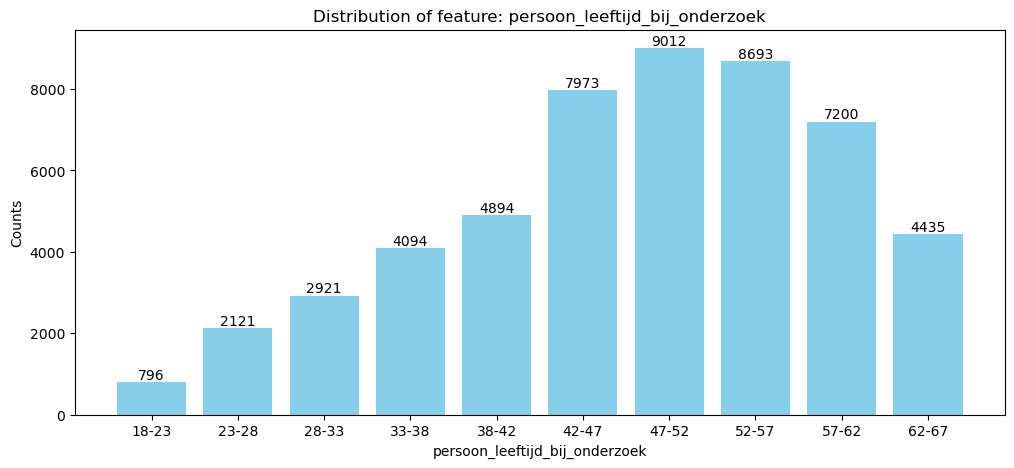

In [71]:
plot_distribution(manipulated_data['persoon_leeftijd_bij_onderzoek'], 'persoon_leeftijd_bij_onderzoek')

Mean:9994.2
{'18-23': 9200, '23-28': 7900, '28-33': 5500, '33-38': 1900, '38-42': 200, '62-67': 1100}


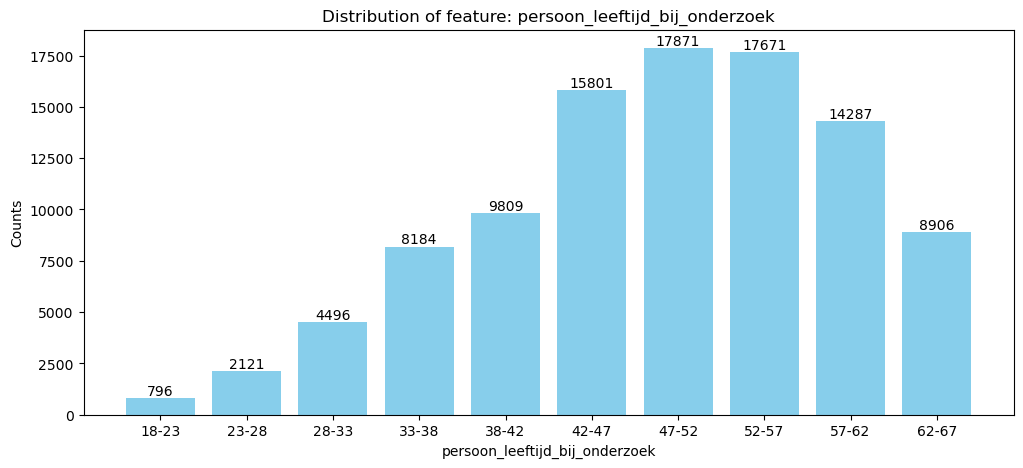

In [72]:
plot_distribution(test_data['persoon_leeftijd_bij_onderzoek'], 'persoon_leeftijd_bij_onderzoek')